In [103]:
import numpy as np
import math
import matplotlib.pyplot as plt
# simulate the infected patients number for a specific period T_total
# this function simulate not strictly numbers of X_n in T_total time, given fixed Lambda, P, Alpha
# Random Horizon: means that the whole trajectory stop once X_n hits 0
# @ param N: is the number of total population can be infected
# @ param t_0: a number that is the time when starting the T-time simulation
# @ param x_0: initial infected patients (greater than 0)
# @ param T_total: is total time for this simulation
# @ param maxi_time: is the maximum time that the whole simulation process can go, can be infinity
# @ param H: is the hospital capacity
def simulation_infected(la, p, al, N, t_0, x_0, T_total, H, maxTime):
    # initialize time and infected patient
    # bind variables to the initial conditions
    x_n = x_0
    # make sure the start is not 0
#     assert(x_n!=0)
    # assign initial time to a know value, noted it can start from
    # not just at 0 time
    t_n = t_0
    # introduce T_H := "the total time above the hospital capacity"
    T_H = 0
    # initiate X_n process trajectory and corresponding T_n process
    X_trajectory = []
    T_trajectory = []
    # loop
    # break condition
    # @ condition1: when the time exceeds the maximum time
    # @ condition2: when the infected patients go to zero
    # @ condition3: when the whole populations are infected! :(
    while (x_n != 0 and
           x_n < N
          ):
        i = x_n
        # q i _ i+1
        q_forward_i = la*p*2*x_n*(N-i)/(N*(N-1))
        # q i _ i-1
        q_backward_i = al*i
        # waiting time rate v_i = (q i _ i+1) + (q i _ i-1)
        v_i = q_forward_i + q_backward_i
        t_i = np.random.exponential(v_i)
        t_n = t_n+t_i
        # calculate T_H before jumping
        if (x_n >= H):
            T_H = min(T_total ,T_H+t_i)

        if ((t_n-t_0) > T_total):
            X_trajectory.append(x_n)
            T_trajectory.append(T_total+t_0)
            return X_trajectory, T_trajectory, T_H, T_total
        
        # jumping probability to STATE i+1 is (q i _ i+1)/v_i
        jump = np.random.binomial(n=1,p=(q_forward_i/v_i))
        
        # change x_n
        if (jump ==1):
            x_n += 1
        elif (jump == 0):
            x_n -= 1            
        
        # add the jumped X_n at t_i time
        X_trajectory.append(x_n)
        # increase time
        T_trajectory.append(t_n)
    
        
        # if hits then zero return
        if (x_n == 0):
            print("*********")
            print(X_trajectory)
            return X_trajectory, T_trajectory, T_H, T_total        
        
#     # also return when the while break condition met
#     return X_trajectory, T_trajectory, T_H, T_total

In [60]:
X_n,T_n,T_H,T = simulation_infected(_lambda,_p,_alpha,N,0,x_n,K,H,maxTime)

In [61]:
T_n

[1.4198467702367815e-07,
 1.0003480751300195e-06,
 2.9685622259049873e-06,
 3.254115349005091e-06,
 3.696897849839259e-06,
 5.301279102298872e-06,
 5.354486683893744e-06,
 5.367348011409498e-06,
 6.893196078976108e-06,
 9.07344607162627e-06,
 1.1356245487410979e-05,
 1.1772778203826088e-05,
 1.3239848283575978e-05,
 1.3306768992163312e-05,
 1.531648767562787e-05,
 1.5518573605021553e-05,
 1.574120257596171e-05,
 1.6639153558394883e-05,
 1.752494702597817e-05,
 1.7559590055768222e-05,
 1.837364797428829e-05,
 1.883128160820568e-05,
 1.8888078555270723e-05,
 1.8916842175483946e-05]

In [62]:
X_n

[9, 8, 7, 8, 7, 6, 7, 8, 7, 8, 7, 8, 7, 6, 7, 6, 5, 4, 3, 4, 3, 2, 1, 0]

In [104]:
# function takes that updates lambda with negative sign
def update_lambda(_lambda, T_H, T, Beta ,stepsize):
    Y_n = T_H/T
    _lambda -= float(stepsize) * (Y_n-Beta)
    return _lambda

# function that updates p with negative sign
def update_p(_p, T_H, T, Beta, stepsize):
    Y_n = T_H/T
    _p -= float(stepsize) * (Y_n-Beta)
    return _p

# function that updates alpha with positive sign
def update_alpha(_alpha, T_H, T, Beta, stepsize):
    Y_n = T_H/T
    _alpha += float(stepsize) * (Y_n-Beta)
    return _alpha

# @ x_0 initial infected patient
# @ _lambda the inital lambda value
# @ _alpha the inital alpha value
# @ p the inital p value 
# @ C is the hospital capacity 
# @ Beta is the target tracking probability 
# @ K is the batch size of each estimate
# @ The batch is defined here as the total K days of simulation starting from a time point
# @ It is not defined as the number of replications of each simulation with T days
# these are all set arbitary atm
x_0 = 10
_lambda = 0.1
_alpha = 1e-8
_p = 0.9
K = 14
H = 2e4
Beta = 0.05
N = 4e6
maxTime = 3e4                                            
stepsize = [0.000001, 2e-11]


trajectory_lambda = []
trajectory_alpha = []
trajectory_X_n = []
trajectory_T_n = []
# use iteration of 5000 as end of all sequential update
iteration = 0
x_n = x_0
t_n = 0

while iteration < 4900:
    
    # simulate K days of X_n obtain T_H/T, starting from t_0 = 0 and x_0 = x_n
    X_n,T_n,T_H,T = simulation_infected(_lambda,_p,_alpha,N,t_n,x_n,K,H,maxTime)
    
    # use K days simulation to update lambda and alpha
    _alpha = max(0,update_alpha(_alpha,T_H,T,Beta,stepsize[1]))
    _lambda = max(0, update_lambda(_lambda,T_H,T,Beta,stepsize[0]))
    
    # update the objective simulation trajectory
    trajectory_alpha.append(_alpha)
    trajectory_lambda.append(_lambda)
    trajectory_X_n.extend(X_n)
    trajectory_T_n.extend(T_n)
    
    # update x_n and t_n using the last (latest) element of objective simulation X_n and T_n
    x_n = X_n[-1]
    t_n = T_n[-1]
    
    # if x_n is zero, jump up to x_0, restart simulation
    if (x_n==0):
        x_n = x_0

    
    iteration+=1
    

*********
[5561, 5562, 5563, 5562, 5561, 5560, 5559, 5560, 5561, 5560, 5559, 5558, 5557, 5556, 5557, 5556, 5557, 5558, 5557, 5556, 5555, 5554, 5555, 5554, 5555, 5556, 5557, 5558, 5559, 5558, 5557, 5558, 5559, 5558, 5557, 5556, 5555, 5556, 5555, 5554, 5553, 5552, 5553, 5552, 5551, 5550, 5551, 5550, 5549, 5548, 5547, 5548, 5549, 5550, 5551, 5550, 5549, 5550, 5551, 5552, 5551, 5550, 5551, 5552, 5551, 5552, 5551, 5552, 5551, 5550, 5549, 5548, 5547, 5546, 5545, 5544, 5545, 5546, 5545, 5544, 5545, 5546, 5545, 5544, 5543, 5542, 5543, 5544, 5543, 5542, 5541, 5540, 5539, 5540, 5539, 5538, 5537, 5536, 5535, 5534, 5533, 5532, 5531, 5530, 5529, 5528, 5527, 5526, 5525, 5524, 5523, 5524, 5525, 5524, 5523, 5522, 5523, 5522, 5521, 5520, 5521, 5522, 5521, 5520, 5519, 5520, 5519, 5518, 5517, 5516, 5517, 5518, 5517, 5516, 5515, 5514, 5513, 5512, 5511, 5510, 5509, 5508, 5509, 5508, 5507, 5506, 5505, 5506, 5507, 5506, 5505, 5504, 5503, 5502, 5503, 5502, 5501, 5502, 5503, 5504, 5503, 5504, 5503, 5502, 5501,

In [101]:
trajectory_T_n[-1]

66069.2347116224

In [102]:
trajectory_X_n[-1]

0

In [69]:
trajectory_alpha

[9.999e-09]

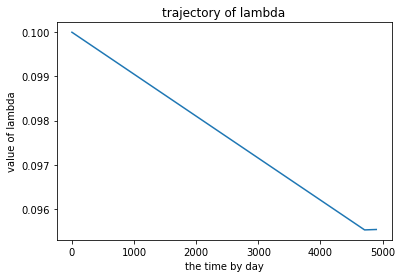

In [107]:
plt.xlabel("the time by day")
plt.ylabel("value of lambda")
plt.title("trajectory of lambda")
plt.plot(trajectory_lambda)
# plt.savefig("trajectory of lambda, experiment3, 2e4")

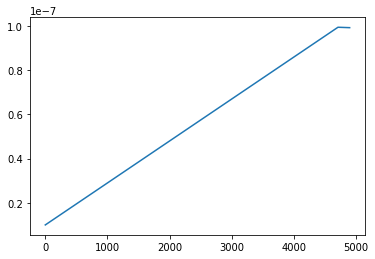

In [106]:
plt.clf()
plt.plot(trajectory_alpha)
# plt.savefig("trajectory of alpha, experiment3, 2e4")

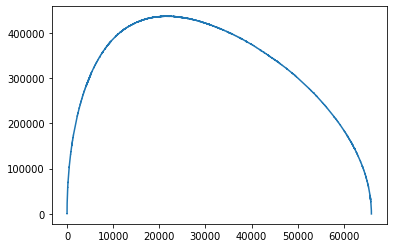

In [105]:
plt.plot(trajectory_T_n,trajectory_X_n)
# plt.savefig("trajectory of simulation, experiment3, 2e4")

In [55]:
len(trajectory_X_n)

2866548

In [53]:
len(trajectory_X_n)

2919245